# Clasificador Bayesiano de Idiomas

Parara reponer las 4 horas de la semana pasada, y como ejercicio de las cosas que ya vimos en clase, quiero que hagan un clasificador de idioma de 3 o 4 lenguas distintas. La característica que utilizará el clasificador, será n-gramas (caracteres) y ustedes deben determinar una n óptima basados en las métricas de evaluación dadas anteriormente. El clasificador, hagan un clasificador tipo Bayesiano (programenlo ustedes, por favor). Utilicen el truco de los exponentes que vimos la penúltima vez.

## Conceptos básicos
Probabilidad que una palabra $w$ esté en un documento de la clase $C$

$$ p(w_i \mid C) $$

Probabilidad de que un documento $D$, contenga todas las palabras $w_i$, dada una clase $C$

$$ p(D\mid C)=\prod_i p(w_i \mid C) $$

Naive Bayes Multinomial (NB)

$$ 
\begin{align}

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ p(c_i)\prod_i p(w_i \mid c_i)^{x_i} \\

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ \log p(c_i) + \sum_i x_i\log p(w_i \mid c_i) \\
                       & = b + \mathbf{w}_k^\top \mathbf{x} \\
\end{align}
$$

donde $b = \log p(C_k)$ y $w_{ki} = \log p_{ki}$.

Laplace Smoothing

$$ \hat{p}(w \mid c) = \frac{\mathrm{count}(w, c) + 1}{\mathrm{count}(c) + \vert V \vert} $$

Fuente: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

## Entrenamiento

In [1]:
# import nltk
# p(C \vert F_1,\dots,F_n) = \frac{p(C) \ p(F_1,\dots,F_n\vert C)}{p(F_1,\dots,F_n)}
from nltk.corpus import floresta, cess_esp, brown
from sklearn.model_selection import train_test_split
import operator
import numpy as np 
import random
import json
from collections import Counter
import matplotlib.pyplot as plt

Defino constantes

- n: Para definir n en n-gramas
- CLASES: Las etiquetas de clase (idiomas) a clasificar
- colores: Colores para gráficas

In [2]:
n = 2 # Agrupar los documentos en n caractéres
CLASES = ['es', 'pt', 'en']
colores = {
    'es': 'r',
    'pt': 'g',
    'en': 'b'
}

seed = 420
random.seed(seed)
np.random.seed(seed)

Función para obtener los n-gramas de una cadena de caracteres

In [3]:
# https://www.nltk.org/_modules/nltk/util.html#ngrams
def obtener_ngramas(text = "", n=2):
    """Función para obtener los ngramas de una cadena de caracteres
    :param str text
    :param n int
    """
    seq = iter(text)
    ngramas = []
    ngrama = ""
    while n > 1:
        # PEP 479, prevent RuntimeError from being raised when StopIteration bubbles out of generator
        try:
            next_item = next(seq)
        except StopIteration:
            # no more data, terminate the generator
            return
        ngrama += next_item
        n -= 1
    for item in seq:
        ngrama += item
        yield ngrama
        ngrama = ngrama[1:]

In [4]:
corpus = {
    'es' : train_test_split(cess_esp.sents()[:6900]),
    'pt' : train_test_split(floresta.sents()[:9000]),
    'en' : train_test_split(brown.sents()[:10000])
}


In [5]:
train_corpus = {
    lang : tt_corpus[0]
    for lang, tt_corpus in corpus.items()
}

In [6]:
test_corpus = {
    lang : tt_corpus[1]
    for lang, tt_corpus in corpus.items()
}

In [7]:
for lang, c in train_corpus.items():
    print(lang)
    print(c[:2], '\n')

es
[['En', 'Bhambayi', 'cientos', 'de', 'casas', 'han', 'sido', 'arrasadas', 'en', 'los', 'enfrentamientos', '.'], ['Si', 'no', ',', 'ahí', 'están', 'las', 'silvas', 'de', 'varia', 'lección', 'o', 'aquellas', 'tentativas', 'a', 'las', 'que', 'Montaigne', 'llamó', 'sencillamente', '-', 'ensayos', '-', '.']] 

pt
[['entre', '1960', 'e', '1991', ',', 'os', 'valores', 'de', 'a', 'taxa', 'de', 'fecundidade', 'passaram', 'de', '94,9', 'por_cento', 'para', '47', 'por_cento', '.'], ['As', 'outras', 'coisas', 'não', 'são', 'tão']] 

en
[['Now', 'if', 'one', 'hydrogen', 'atom', 'were', 'placed', 'at', 'the', 'surface', 'of', 'a', 'large', 'sphere', 'of', 'hydrogen', 'atoms', ',', 'it', 'would', 'be', 'subject', 'both', 'to', 'the', 'gravitation', 'of', 'the', 'sphere', 'and', 'the', 'charge-excess', 'of', 'all', 'those', 'atoms', 'in', 'the', 'sphere', '.'], ['The', 'committee', 'remains', 'unresponsive', '.']] 



In [8]:
for lang, c in test_corpus.items():
    print(lang)
    print(c[:2], '\n')

es
[['Como', 'se', 'ha', 'visto', 'en', 'el', 'apartado', 'anterior', ',', 'los', 'polímeros', 'orgánicos', 'dopados', 'presentan', 'serias', 'dificultades', 'a_causa', 'fundamentalmente', 'de', 'su', 'baja', 'estabilidad', 'térmica', 'y', 'química', ',', 'lo', 'que', 'por', 'el', 'momento', 'limita', 'sus', 'aplicaciones', 'prácticas', '.'], ['Dos', 'comisiones', 'de', 'arbitraje', 'de', 'la', 'OMC', 'dictaminaron', ',', 'en', 'agosto', 'del', 'año', 'pasado', ',', 'tras', 'apelación', ',', 'que', 'los', 'subsidios', 'concedidos', 'por', 'ambas', 'empresas', 'a', 'sus', 'respectivas', 'industrias', 'eran', 'ilegales', 'de_acuerdo_con', 'los', 'convenios', 'multilaterales', 'sobre', 'esta', 'materia', '.']] 

pt
[['Esse', 'quadro', 'de', 'inseguranças', 'e', 'de', 'incertezas', 'que', 'já', 'dura', 'há', 'duas', 'décadas', 'contribui', 'para', 'transformar', 'o', 'integrismo', ',', 'o', 'racismo', ',', 'a', 'intolerância', 'política', 'em', 'um', 'formidável', 'desafio', 'a', 'o', 'sis

Leo cada línea de cada documento del corpus

In [9]:
# corpus = {
#     lang : open(f'corpus/{lang}.txt', 'r', encoding='utf-8').readlines() 
#     for lang in CLASES
# }

In [10]:
# Para corpus.raw()
# ngramas = {
#     index : [ngrama for ngrama in list(obtener_ngramas(corpus_lang, n))]
#     for index, corpus_lang in train_corpus.items()
# }

# Para corpus.sents()
ngramas = {
    index : [ngrama for sent in corpus_lang for ngrama in (obtener_ngramas(' '.join(sent), n))]
    for index, corpus_lang in train_corpus.items()
}

# Para 'corpus/lang.txt'
# ngramas = {
#     index : [ngrama for sent in corpus_lang for ngrama in (obtener_ngramas(sent, n))]
#     for index, corpus_lang in train_corpus.items()
# }

In [11]:
for index, ngramas_lang in ngramas.items():
    print('Lenguaje: ', index)
    print('N-gramas: ', len(ngramas_lang))
    print(ngramas_lang[:15])
    print('')

Lenguaje:  es
N-gramas:  819557
['En', 'n ', ' B', 'Bh', 'ha', 'am', 'mb', 'ba', 'ay', 'yi', 'i ', ' c', 'ci', 'ie', 'en']

Lenguaje:  pt
N-gramas:  847102
['en', 'nt', 'tr', 're', 'e ', ' 1', '19', '96', '60', '0 ', ' e', 'e ', ' 1', '19', '99']

Lenguaje:  en
N-gramas:  870574
['No', 'ow', 'w ', ' i', 'if', 'f ', ' o', 'on', 'ne', 'e ', ' h', 'hy', 'yd', 'dr', 'ro']



In [12]:
todos_ngramas = [ngrama for ngramas_lang in ngramas.values() for ngrama in ngramas_lang]
tam_corpus = len(todos_ngramas)
print(f'Tamaño corpus: {tam_corpus} n-gramas')
print(todos_ngramas[0:10])

Tamaño corpus: 2537233 n-gramas
['En', 'n ', ' B', 'Bh', 'ha', 'am', 'mb', 'ba', 'ay', 'yi']


### Probabilidades a priori

Calculo las probabilidades a priori de las clases

In [13]:
prob_priori = {
    clase : len(ngramas_lang)/tam_corpus
    for clase, ngramas_lang in ngramas.items()
}

# Guardo las probabilidades priori
with open(f'modelos/{n}gramas_priori.json', 'w', encoding='utf-8') as f:
    json.dump(prob_priori, f)

prob_priori

{'es': 0.323012115954664, 'pt': 0.33386843068807637, 'en': 0.3431194533572597}

### Verisimilitud (Likelihood)

Ahora, calculo la probabilidad de cada n-grama dada la clase con Laplace Smoothing

Primero, cuento las ocurrencias de cada n-grama en cada clase 

In [14]:
freq_ngramas = {
    clase : Counter(ngramas_lang)
    for clase, ngramas_lang in ngramas.items()
}
for clase, counters in freq_ngramas.items():
    print(f'Idioma: {clase}')
    print(f'Número de tipos: {len(counters)}')
    print(counters.most_common(10), '\n')

Idioma: es
Número de tipos: 2012
[('a ', 23203), ('e ', 21817), ('s ', 20487), ('o ', 16760), ('de', 15645), (' d', 14141), (' e', 13681), ('en', 12878), ('n ', 12629), ('es', 11549)] 

Idioma: pt
Número de tipos: 2437
[('e ', 26656), ('a ', 26073), ('o ', 25761), ('s ', 21236), ('de', 18060), (' a', 17324), (' d', 15472), (' e', 13013), (' o', 11704), ('m ', 10987)] 

Idioma: en
Número de tipos: 1502
[('e ', 27673), (' t', 20016), ('s ', 19237), ('th', 16968), ('he', 16013), (' a', 14852), ('d ', 13688), ('t ', 13364), ('n ', 13115), ('in', 12027)] 



Ahora, la frecuencia total de los tipos en todo el corpus

In [15]:
freq_total = sum(freq_ngramas.values(), Counter())
tipos = [tipo for tipo in freq_total.keys()]
print(f'Número de tipos: {len(tipos)}')
print(tipos[:10])
# plt.figure()
# plt.title(f'Rango vs frecuencia en bigramas (TOTAL)')
# freq = [fr[1] for fr in freq_total.most_common()]
# ranks = range(1, len(freq)+1)
# plt.scatter(np.log(ranks), np.log(freq), color='#9f0ff0')
# plt.show()

Número de tipos: 2938
['En', 'n ', ' B', 'Bh', 'ha', 'am', 'mb', 'ba', 'ay', 'yi']


Probabilidad de ngrama $w$ en clase c

$ \hat{p}(w \mid c) = \frac{\mathrm{count}(w, c) + 1}{\mathrm{count}(c) + \vert V \vert} $

```python
likelihoods[w][c]
```

In [16]:
likelihoods = {
    tipo : {
        lang : (freq[tipo] + 1) / (len(freq) + tam_corpus)
        for lang, freq in freq_ngramas.items()
    }
    for tipo in tipos
}

# Guardo las probabilidades priori
with open(f'modelos/{n}gramas_likelihoods.json', 'w', encoding='utf-8') as f:
    json.dump(likelihoods, f)

ejemplos_likelihood = ['eo', 'el', 'wh', 'eu', 'th']
for ejemplo in ejemplos_likelihood:
    print(f'Probabilidad de ngrama {ejemplo} dada la clase (lenguaje)')
    print(likelihoods[ejemplo], '\n')

Probabilidad de ngrama eo dada la clase (lenguaje)
{'es': 0.00016185913529415238, 'pt': 9.804423409340583e-05, 'en': 0.000135894451370466} 

Probabilidad de ngrama el dada la clase (lenguaje)
{'es': 0.0031162806267217226, 'pt': 0.0010320238456177377, 'en': 0.0011241819252501737} 

Probabilidad de ngrama wh dada la clase (lenguaje)
{'es': 7.876356948620555e-07, 'pt': 1.1812558324506727e-06, 'en': 0.0007342239343610105} 

Probabilidad de ngrama eu dada la clase (lenguaje)
{'es': 7.167484823244704e-05, 'pt': 0.0003976894635917265, 'en': 3.5056829483975285e-05} 

Probabilidad de ngrama th dada la clase (lenguaje)
{'es': 1.5752713897241108e-05, 'pt': 2.992514775541704e-05, 'en': 0.006684037522624457} 



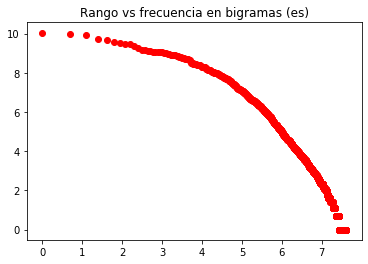

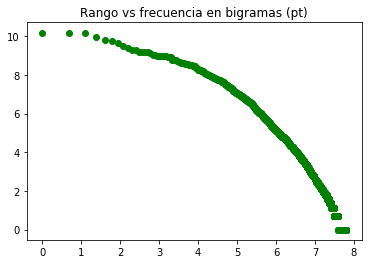

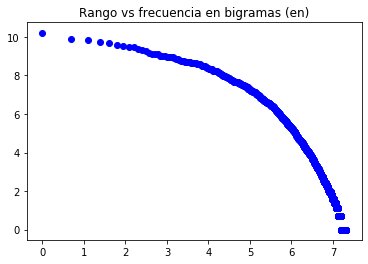

In [17]:
for clase, counters in freq_ngramas.items():
    plt.figure()
    plt.title(f'Rango vs frecuencia en bigramas ({clase})')
    freq = [fr[1] for fr in counters.most_common()]
    ranks = range(1, len(freq)+1)
    plt.scatter(np.log(ranks), np.log(freq), color=colores[clase])
    plt.show()

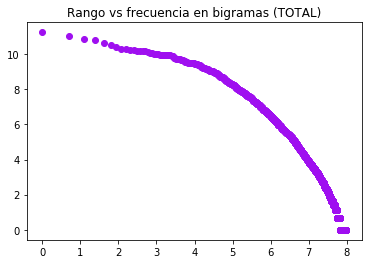

In [18]:
plt.figure()
plt.title(f'Rango vs frecuencia en bigramas (TOTAL)')
freq = [fr[1] for fr in freq_total.most_common()]
ranks = range(1, len(freq)+1)
plt.scatter(np.log(ranks), np.log(freq), color='#9f0ff0')
plt.show()

In [19]:
hapax = []
for item in reversed(freq_total.most_common()):
    if (item[1]==1):
        hapax.append(item)
    else:
        break
len(hapax)

434

In [20]:
# from itertools import count
# from collections import defaultdict
# from functools import partial

# def hashing_v1(seq):
#     mapping = defaultdict(partial(next, count()))
#     return [mapping[tuple(el)] for el in seq]

# def hashing_v2(seq):
#     mapping = defaultdict(partial(next, count()))
#     result = []
#     for le in seq:
#         le.flags.writeable = False
#         result.append(mapping[le.data])
#     return result

## Clasificación

Naive Bayes Multinomial (NB)

$$ 
\begin{align}

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ p(c_i)\prod_i p(w_i \mid c_i)^{x_i} \\

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ \log p(c_i) + \sum_i x_i\log p(w_i \mid c_i) \\
                       & = b + \mathbf{w}_k^\top \mathbf{x} \\
\end{align}
$$

donde $b = \log p(C_k)$ y $w_{ki} = \log p_{ki}$.

In [21]:
def clasificar(prueba, prob_priori, likelihood):
    return max(prob_clases(prueba, prob_priori, likelihood).items(), key=operator.itemgetter(1))

def prob_clases(prueba, prob_priori, likelihood):
    probabilidades = {
        lang : 0 for lang in prob_priori.keys()
    }
    for lang in probabilidades.keys():
        wx = 0
        for ngrama, prob in prueba.items():
            try:
                wx += np.log(likelihood[ngrama][lang])*prob
            except KeyError as err:
                print(f'Advertencia: El n-grama {err} no está en el vocabulario.')
                # return { lang : 0 for lang in prob_priori.keys() }
        # Si quitamos np.log(prob_priori[lang]), asumimos que las clases son equiprobables
        probabilidades[lang] = wx #+ np.log(prob_priori[lang])
    return probabilidades

In [22]:
# test_corpus = {
#     'es' : ["¿ Sabías que los mosquitos suelen explotar al contacto ?", "Los oídos de los camellos son 100 veces más grandes que los de una hormiga rey"],
#     'pt' : ["Pensando melhor , nunca mais vou ter aquele batido de aveia .", "As perucas vermelhas dos pinguins ajudam a cobrir as suas penas"],
#     'en' : ["Sometimes when I am alone in bed I think about my lightbulb", "Despite everything you did to me , I still want you to die in a terrific accident ."]
# }

In [23]:
test_ngramas = {
    lang : [list(obtener_ngramas(" ".join(frase), n)) for frase in frases]
    for lang, frases in test_corpus.items() 
}
# test_ngramas = {
#     lang : [list(obtener_ngramas(frase, n)) for frase in frases]
#     for lang, frases in test_corpus.items() 
# }

print(test_ngramas['es'][0])

['Co', 'om', 'mo', 'o ', ' s', 'se', 'e ', ' h', 'ha', 'a ', ' v', 'vi', 'is', 'st', 'to', 'o ', ' e', 'en', 'n ', ' e', 'el', 'l ', ' a', 'ap', 'pa', 'ar', 'rt', 'ta', 'ad', 'do', 'o ', ' a', 'an', 'nt', 'te', 'er', 'ri', 'io', 'or', 'r ', ' ,', ', ', ' l', 'lo', 'os', 's ', ' p', 'po', 'ol', 'lí', 'ím', 'me', 'er', 'ro', 'os', 's ', ' o', 'or', 'rg', 'gá', 'án', 'ni', 'ic', 'co', 'os', 's ', ' d', 'do', 'op', 'pa', 'ad', 'do', 'os', 's ', ' p', 'pr', 're', 'es', 'se', 'en', 'nt', 'ta', 'an', 'n ', ' s', 'se', 'er', 'ri', 'ia', 'as', 's ', ' d', 'di', 'if', 'fi', 'ic', 'cu', 'ul', 'lt', 'ta', 'ad', 'de', 'es', 's ', ' a', 'a_', '_c', 'ca', 'au', 'us', 'sa', 'a ', ' f', 'fu', 'un', 'nd', 'da', 'am', 'me', 'en', 'nt', 'ta', 'al', 'lm', 'me', 'en', 'nt', 'te', 'e ', ' d', 'de', 'e ', ' s', 'su', 'u ', ' b', 'ba', 'aj', 'ja', 'a ', ' e', 'es', 'st', 'ta', 'ab', 'bi', 'il', 'li', 'id', 'da', 'ad', 'd ', ' t', 'té', 'ér', 'rm', 'mi', 'ic', 'ca', 'a ', ' y', 'y ', ' q', 'qu', 'uí', 'ím', 'mi

In [24]:
test_freq = {
    lang : [Counter(ngrama) for ngrama in ngramas]
    for lang, ngramas in test_ngramas.items()
}

print(test_freq['es'][0])

Counter({'s ': 9, 'a ': 6, 'ta': 6, 'ic': 6, 'o ': 5, 'en': 5, 'nt': 5, 'ca': 5, ' s': 4, 'e ': 4, ' e': 4, ' a': 4, 'ad': 4, 'os': 4, ' p': 4, 'me': 4, 'es': 4, 'se': 3, 'do': 3, 'er': 3, 'or': 3, ' l': 3, ' d': 3, 'li': 3, 'mi': 3, 'om': 2, 'mo': 2, 'st': 2, 'to': 2, 'n ': 2, 'el': 2, 'l ': 2, 'ap': 2, 'pa': 2, 'an': 2, 'te': 2, 'ri': 2, 'io': 2, 'r ': 2, ' ,': 2, ', ': 2, 'lo': 2, 'po': 2, 'ím': 2, 'pr': 2, 'as': 2, 'de': 2, 'us': 2, 'da': 2, 'su': 2, ' q': 2, 'qu': 2, 'Co': 1, ' h': 1, 'ha': 1, ' v': 1, 'vi': 1, 'is': 1, 'ar': 1, 'rt': 1, 'ol': 1, 'lí': 1, 'ro': 1, ' o': 1, 'rg': 1, 'gá': 1, 'án': 1, 'ni': 1, 'co': 1, 'op': 1, 're': 1, 'ia': 1, 'di': 1, 'if': 1, 'fi': 1, 'cu': 1, 'ul': 1, 'lt': 1, 'a_': 1, '_c': 1, 'au': 1, 'sa': 1, ' f': 1, 'fu': 1, 'un': 1, 'nd': 1, 'am': 1, 'al': 1, 'lm': 1, 'u ': 1, ' b': 1, 'ba': 1, 'aj': 1, 'ja': 1, 'ab': 1, 'bi': 1, 'il': 1, 'id': 1, 'd ': 1, ' t': 1, 'té': 1, 'ér': 1, 'rm': 1, ' y': 1, 'y ': 1, 'uí': 1, 'ue': 1, ' m': 1, 'im': 1, 'it': 1, '

In [25]:
test_prob = {
    lang : [
        {
            ngrama : freq/len(test_ngramas[lang][i_ejemplo])
            for ngrama, freq in freqs.items()
        }
        for i_ejemplo, freqs in enumerate(lista_freq)
    ]
    for lang, lista_freq in test_freq.items()
}

print(test_prob['es'][0])

{'Co': 0.004366812227074236, 'om': 0.008733624454148471, 'mo': 0.008733624454148471, 'o ': 0.021834061135371178, ' s': 0.017467248908296942, 'se': 0.013100436681222707, 'e ': 0.017467248908296942, ' h': 0.004366812227074236, 'ha': 0.004366812227074236, 'a ': 0.026200873362445413, ' v': 0.004366812227074236, 'vi': 0.004366812227074236, 'is': 0.004366812227074236, 'st': 0.008733624454148471, 'to': 0.008733624454148471, ' e': 0.017467248908296942, 'en': 0.021834061135371178, 'n ': 0.008733624454148471, 'el': 0.008733624454148471, 'l ': 0.008733624454148471, ' a': 0.017467248908296942, 'ap': 0.008733624454148471, 'pa': 0.008733624454148471, 'ar': 0.004366812227074236, 'rt': 0.004366812227074236, 'ta': 0.026200873362445413, 'ad': 0.017467248908296942, 'do': 0.013100436681222707, 'an': 0.008733624454148471, 'nt': 0.021834061135371178, 'te': 0.008733624454148471, 'er': 0.013100436681222707, 'ri': 0.008733624454148471, 'io': 0.008733624454148471, 'or': 0.013100436681222707, 'r ': 0.00873362445

In [26]:
for lang, lang_list in test_prob.items():
    for id_item, test_item in enumerate(lang_list[9:11]):
        print(" ".join(test_corpus[lang][id_item]))
        pred_prob = prob_clases(test_item, prob_priori, likelihoods)
        print('Probabilidades (log): ', pred_prob)
        print('Predicción: ', max(pred_prob.items(), key=operator.itemgetter(1))[0])
        print()

Como se ha visto en el apartado anterior , los polímeros orgánicos dopados presentan serias dificultades a_causa fundamentalmente de su baja estabilidad térmica y química , lo que por el momento limita sus aplicaciones prácticas .
Probabilidades (log):  {'es': -6.413749726925667, 'pt': -6.7124813285248734, 'en': -7.437433771800236}
Predicción:  es

Dos comisiones de arbitraje de la OMC dictaminaron , en agosto del año pasado , tras apelación , que los subsidios concedidos por ambas empresas a sus respectivas industrias eran ilegales de_acuerdo_con los convenios multilaterales sobre esta materia .
Advertencia: El n-grama 'Qi' no está en el vocabulario.
Advertencia: El n-grama 'Qi' no está en el vocabulario.
Advertencia: El n-grama 'Qi' no está en el vocabulario.
Probabilidades (log):  {'es': -6.8342207735274085, 'pt': -7.163305887757092, 'en': -7.806452207247957}
Predicción:  es

Esse quadro de inseguranças e de incertezas que já dura há duas décadas contribui para transformar o integri

In [27]:
predicciones = {}
for lang, lang_list in test_prob.items():
    predicciones[lang] = []
    for test_item in lang_list:
        predicciones[lang].append(clasificar(test_item, prob_priori, likelihoods))

ulario.
Advertencia: El n-grama 'Mw' no está en el vocabulario.
Advertencia: El n-grama 'Mw' no está en el vocabulario.
Advertencia: El n-grama 'Mw' no está en el vocabulario.
Advertencia: El n-grama 'OY' no está en el vocabulario.
Advertencia: El n-grama 'OY' no está en el vocabulario.
Advertencia: El n-grama 'OY' no está en el vocabulario.
Advertencia: El n-grama 'Qi' no está en el vocabulario.
Advertencia: El n-grama 'Qi' no está en el vocabulario.
Advertencia: El n-grama 'Qi' no está en el vocabulario.
Advertencia: El n-grama 'Yn' no está en el vocabulario.
Advertencia: El n-grama 'Yn' no está en el vocabulario.
Advertencia: El n-grama 'Yn' no está en el vocabulario.
Advertencia: El n-grama 'yú' no está en el vocabulario.
Advertencia: El n-grama 'yú' no está en el vocabulario.
Advertencia: El n-grama 'yú' no está en el vocabulario.
Advertencia: El n-grama "P'" no está en el vocabulario.
Advertencia: El n-grama "P'" no está en el vocabulario.
Advertencia: El n-grama "P'" no está en 

In [30]:
freq_pred = {
    lang : Counter([freq[0] for freq in freqs])
    for lang, freqs in predicciones.items()
}
print(freq_pred)

{'es': Counter({'es': 1494, 'pt': 11, 'en': 3}), 'pt': Counter({'pt': 2236, 'es': 10, 'en': 4}), 'en': Counter({'en': 2484, 'pt': 9, 'es': 7})}
